In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pprint

Pretty printing has been turned OFF


In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt
import sys

In [4]:
sys.path.append('../codes')

In [5]:
from VMSfunctions.VMS import *
from VMSfunctions.Common import Peak

# Generate Fake Peaks

In [6]:
from VMSfunctions.Common import load_obj
from VMSfunctions.DataGenerator import PeakSampler

In [7]:
m = Sample_Dataset('../../../beer_data/peak_sampler_4_beers.p',50)

# Basic Scanning Methods

In [8]:
test1_result = []
test2_result = []
test3_result = []
test4_result = []
test5_result = []
test6_result = []

for i in range(0,100):
    Data_test1=Sample_Dataset('../../../beer_data/peak_sampler_4_beers.p',10)
    Data_test2=Sample_Dataset('../../../beer_data/peak_sampler_4_beers.p',50)
    Data_test3=Sample_Dataset('../../../beer_data/peak_sampler_4_beers.p',100)
    test1=Dia_Basic(Data_test1,10,"even")
    test2=Dia_Basic(Data_test1,10,"percentile")
    test3=Dia_Basic(Data_test2,10,"even")
    test4=Dia_Basic(Data_test2,10,"percentile")
    test5=Dia_Basic(Data_test3,10,"even")
    test6=Dia_Basic(Data_test3,10,"percentile")
    test1_result.append(test1.entropy())
    test2_result.append(test2.entropy())
    test3_result.append(test3.entropy())
    test4_result.append(test4.entropy())
    test5_result.append(test5.entropy())
    test6_result.append(test6.entropy())
    
test_result = [test1_result,test2_result,test3_result,test4_result,test5_result,test6_result]

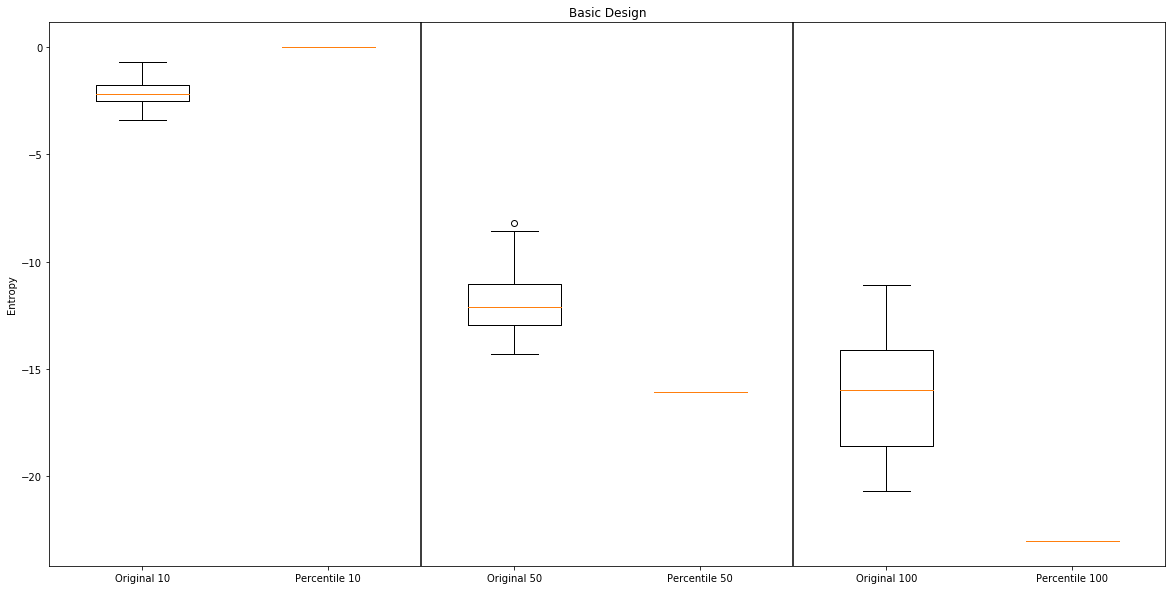

In [9]:
plt.figure(figsize=(20,10))
plt.axvline(x=2.5,color='k')
plt.axvline(x=4.5,color='k')
plt.boxplot(test_result)
plt.ylabel("Entropy")
plt.title("Basic Design")
plt.xticks([1,2,3,4,5,6],["Original 10","Percentile 10","Original 50","Percentile 50","Original 100","Percentile 100"])
plt.show()

# Kaufmann Scanning Method

Need to update ms1_range to be [(min,max)]

In [29]:
import math
class Dia_Kaufmann(object):
    def __init__(self,dataset,num_windows,window_type,kaufmann_design,rt=0,ms_level=2,ms1_range=[[None],[None]],range_slack=0.01):
        if num_windows!=64:
            print("num_windows must equal 64. Has not been set up for any other values yet.")
            return None
        self.locations = []
        self.scan_results = []
        # if no ms1_range provided, initialise the scan range from dataset
        if ms1_range==[[None],[None]]:
            ms1_range_difference = dataset.ms1_range[0][1] - dataset.ms1_range[0][0]
            ms1_range = [[dataset.ms1_range[0][0] - range_slack*ms1_range_difference],[dataset.ms1_range[0][1] + range_slack*ms1_range_difference]]
        else:
            ms1_range_difference = ms1_range[0][1] - ms1_range[0][0] 
        # get names
        self.ms1_names = dataset.ms1_names
        self.ms2_names = dataset.ms2_names
        # Create bin_walls        
        if window_type=="even":
            self.bin_walls=[min(dataset.ms1_values())]
            for window_index in range(0,num_windows):
                self.bin_walls.append(ms1_range[0][0] + ((window_index+1)/num_windows)*ms1_range_difference)
            self.bin_walls[0] = self.bin_walls[0] - range_slack*ms1_range_difference
            self.bin_walls[-1] = self.bin_walls[-1] + range_slack*ms1_range_difference
        elif window_type=="percentile":
            self.bin_walls = np.percentile(dataset.ms1_values(),range(0,100 + int(100/num_windows),int(100/num_windows))).tolist()
            self.bin_walls[0] = self.bin_walls[0] - range_slack*ms1_range_difference
            self.bin_walls[-1] = self.bin_walls[-1] + range_slack*ms1_range_difference
        else:
            sys.exit("Incorrect window_type specified")
        # use separate class which creates windows here
        self.locations=Kaufmann_Windows(self.bin_walls,kaufmann_design)
        # scan locations
        self.scan_results = []
        for window_index in range(0,len(self.locations)):
            self.scan_results.append(Dataset_Scan(dataset,ms_level,rt,self.location[window_index]).scan_result)
        
class Kaufmann_Windows(object):
    def __init__(self,bin_walls,kaufmann_design):
        if kaufmann_design == "nested":
            self.locations = []
            for i in range(0,8):
                self.locations.append([(bin_walls[(0+i*8)],bin_walls[(8+i*8)])])
            locations_internal = [[],[],[],[]]
            for i in range(0,4):
                locations_internal[0].append((bin_walls[(4 + i*16)],bin_walls[(12 + i*16)]))
                locations_internal[1].append((bin_walls[(2 + i*16)],bin_walls[(6 + i*16)]))
                locations_internal[1].append((bin_walls[(10 + i*16)],bin_walls[(14 + i*16)]))
                locations_internal[2].append((bin_walls[(1 + i*16)],bin_walls[(3 + i*16)]))
                locations_internal[2].append((bin_walls[(9 + i*16)],bin_walls[(11 + i*16)]))
                locations_internal[3].append((bin_walls[(5 + i*16)],bin_walls[(7 + i*16)]))
                locations_internal[3].append((bin_walls[(13 + i*16)],bin_walls[(15 + i*16)]))
            self.locations.append(locations_internal)
        else:
            print("not done yet")

In [31]:
Kaufmann_Windows(Dia_Kaufmann(m,64,"even",1).bin_walls,kaufmann_design="nested").locations

[(94.80293705876167, 136.54661479064703), (190.21705758878534, 231.96073532067066), (285.631178118809, 327.37485585069436), (381.04529864883267, 422.788976380718)]

[(82.8761719925087, 100.76631959188813), (130.58323225752054, 148.47337985689998), (178.29029252253235, 196.18044012191183), (225.99735278754423, 243.88750038692365), (273.70441305255605, 291.59456065193547), (321.41147331756787, 339.3016209169473), (369.1185335825797, 387.0086811819591), (416.8255938475915, 434.715741446971)]


[[(70.94940692625575, 118.65646719126758)], [(118.65646719126758, 166.36352745627943)], [(166.36352745627943, 214.07058772129125)], [(214.07058772129125, 261.77764798630307)], [(261.77764798630307, 309.4847082513149)], [(309.4847082513149, 357.19176851632676)], [(357.19176851632676, 404.8988287813386)], [(404.8988287813386, 456.4224538675513)]]

In [18]:
        if window_type=="even":
            for window_index in range(0,num_windows):
                ms1_window_range = [(ms1_range[0][0] + window_index*((ms1_range_difference * (1 + 2*range_slack))/num_windows),ms1_range[0][0] + (window_index+1)*((ms1_range_difference * (1 + 2*range_slack))/num_windows))]
                self.locations.append(ms1_window_range)
                self.scan_results.append(Dataset_Scan(dataset,ms_level,rt,ms1_window_range).scan_result)
        elif window_type=="percentile":
            adjusted_percentiles = np.percentile(dataset.ms1_values(),range(0,100 + int(100/num_windows),int(100/num_windows))).tolist()
            adjusted_percentiles[0] = adjusted_percentiles[0] - range_slack*ms1_range_difference
            adjusted_percentiles[-1] = adjusted_percentiles[-1] + range_slack*ms1_range_difference
            for window_index in range(0,num_windows):
                ms1_window_range = [(adjusted_percentiles[window_index],adjusted_percentiles[window_index+1])]
                self.locations.append(ms1_window_range)
                self.scan_results.append(Dataset_Scan(dataset,ms_level,rt,ms1_window_range).scan_result)
        else:
            sys.exit("Incorrect window_type specified")
        self.ms1_names = dataset.ms1_names
        self.ms2_names = dataset.ms2_names
        
    def bin_walls(self):
        bin_walls = list(set(np.array(sum(d1.locations,[])).flatten()))
        return(bin_walls)
    
    def location_all(self):
        location_all = []
        for i in range(0,len(self.ms1_names)):
            found=False
            j=0
            while found==False:
                if self.scan_results[j][i]==1:
                    location_all.append(self.locations[j])
                    found=True
                else:
                    j+=1  
        return(location_all)
            
    def entropy(self):
        entropy_vec = []
        for i in range(0,len(self.locations)):
            entropy_vec.extend([0])
            for j in range(0,len(self.ms1_names)):
                if self.locations[i]==self.location_all()[j]:
                    entropy_vec[i] +=1
        entropy_vec_nozero = [value for value in entropy_vec if value != 0]
        entropy = sum([math.log(1/y) for y in entropy_vec_nozero])
        return(entropy)

1 3 5 7 9


In [31]:
m.ms1_range

[([76.89291351066741], [430.7099399460854])]

In [32]:
[1]

[1]

In [21]:
x = [1,2,3,4]
i=1
x[0+i*1]

2